# Voxel Selector

A SDF voxel selector based on a voxelgrid input

## Imports

In [17]:
import os
import json
import torch
# some utility function for visualization
import utils
from utils.util_3d import init_mesh_renderer, sdf_to_mesh
from utils.demo_util import get_shape_comp_opt
from utils.demo_util import get_shape_comp_model
from utils.qual_util import save_mesh_as_gif, get_partial_shape_by_voxels, get_partial_shape_by_range, get_shape_comp_input_mesh
from IPython.display import Image as ipy_image
from IPython.display import display

%reload_ext autoreload
%autoreload 2

In [2]:
""" setup dir """
res_dir = 'results'
if not os.path.exists(res_dir): os.mkdir(res_dir)

""" setup opt"""
gpu_id = 0
opt = get_shape_comp_opt(gpu_id=gpu_id)

""" setup different model """
model = get_shape_comp_model(opt)    
model.eval()

""" setup renderer """
dist, elev, azim = 1.7, 20, 110
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: saved_ckpt/pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth


## Import the SDF

In [3]:
sdfPath = "/srvgentjkd98p2/L/Recordings/2015-01 ShapeNetCore/03001627/1a8bbf2994788e2743e99e0cae970928/models/model_normalized_sdf.pt"
sdf = torch.load(sdfPath,map_location=torch.device('cuda'))

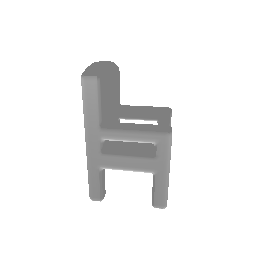

In [4]:
gen_sdf_as_mesh = sdf_to_mesh(sdf) 

# save as gif
gif_name = f'{res_dir}/shape-example.gif'
save_mesh_as_gif(mesh_renderer, gen_sdf_as_mesh, nrow=1, out_name=gif_name)
ipy_image(gif_name)

## Get The Partial Range

### By Voxels

In [24]:
# Load the JSON file
with open('./demo_data/voxelgrid_half.txt', 'r') as file:
    data = json.load(file)
voxels = data['voxels']
occ_grid = []
for voxel in voxels:
    id = voxel['gridIndex']
    occ_grid.append([id['x'], id['y'], id['z']])

shape_comp_input = get_partial_shape_by_voxels(sdf, occ_grid)

### By Range

In [ ]:
completionPercent = "50"
# range: -1 ~ 1.
# x: left-to-right; y: bottom-to-top; z: front-to-back
min_x, max_x = 0., 1.
min_y, max_y = -1, 1.
min_z, max_z = -1., 1.
input_range = {'x1': min_x, 'x2': max_x, 'y1': min_y, 'y2': max_y, 'z1': min_z, 'z2': max_z}

shape_comp_input = get_partial_shape_by_range(sdf, input_range)

### Get Partial Mesh

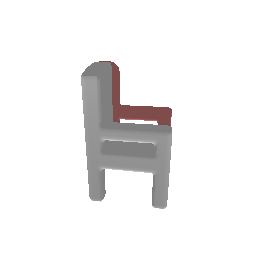

In [22]:
input_mesh = get_shape_comp_input_mesh(shape_comp_input['sdf'], shape_comp_input['sdf_missing'])

# save as gif
gif_name = f'{res_dir}/shape-comp-struct-input-inp.gif'
save_mesh_as_gif(mesh_renderer, input_mesh, nrow=1, out_name=gif_name)
display(ipy_image(gif_name))

## Shape Completion

[*] autoregressively inferencing...: 100%|██████████| 256/256 [00:11<00:00, 21.81it/s]


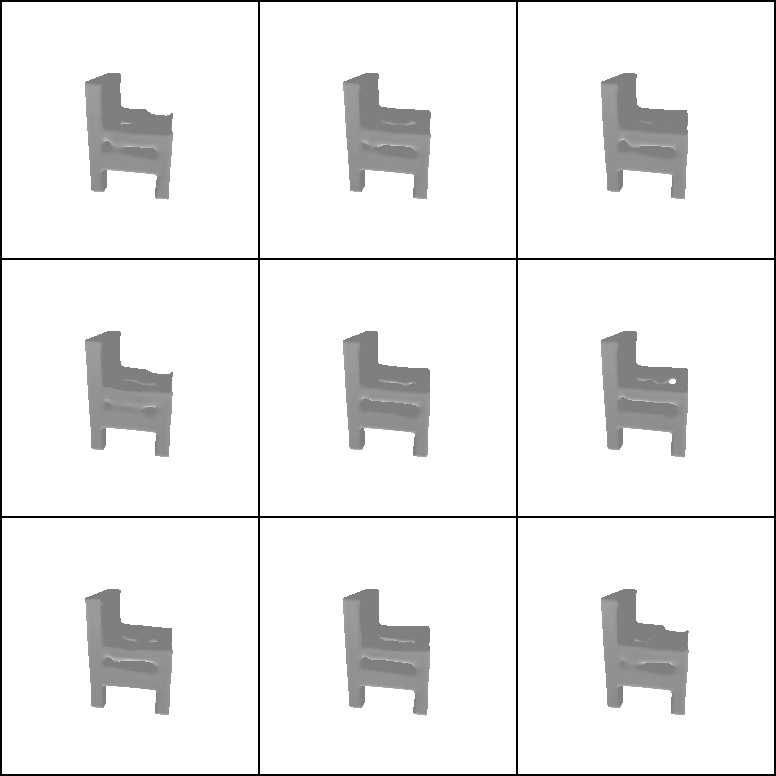

In [23]:
""" perform shape completion """
input_mesh, comp_sdf = model.shape_comp(shape_comp_input, bs=9, topk=30)
gen_mesh = sdf_to_mesh(comp_sdf)          # completed shape

# save as gif
gen_gif_name = f'{res_dir}/shape-comp-struct-input-gen.gif'
save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)
display(ipy_image(gen_gif_name))